In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir("/content/drive/MyDrive/dataset")
!ls

channels  final_keywords.txt  videos


In [3]:
import csv
import re

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from concurrent.futures import ThreadPoolExecutor
from collections import defaultdict

# Educational Content: Indian vs The World

Are Indian people devoted into making educational videos?

In [7]:
df_channel_edu = pd.read_csv('channels/education_channel_with_country.csv')
df_channel_other = pd.read_csv('channels/other_channel_with_country.csv')

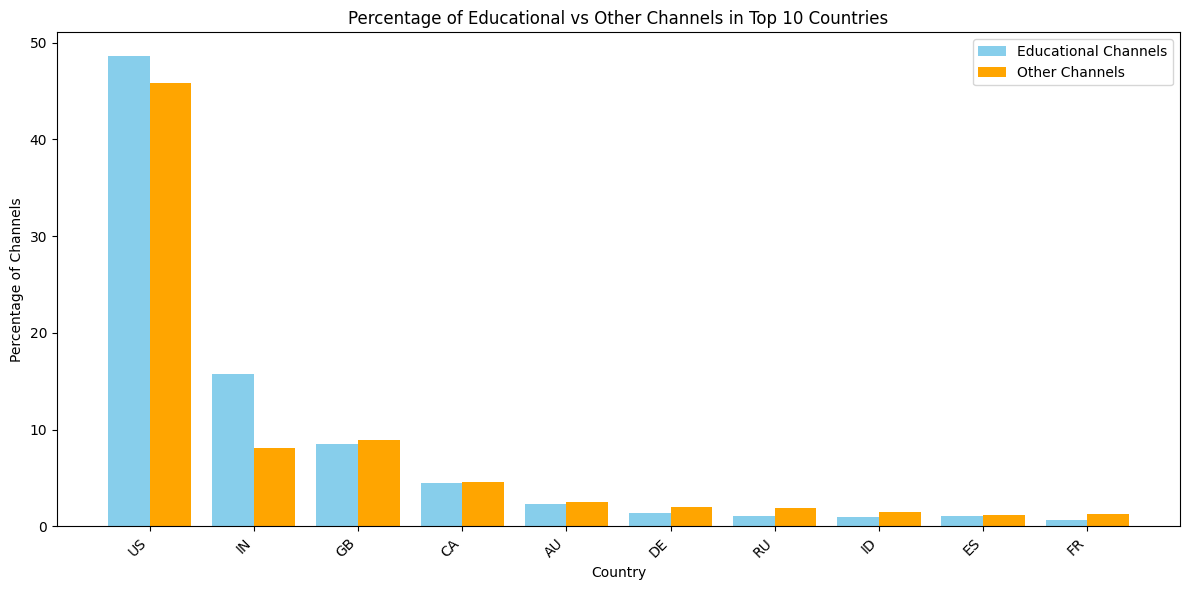

In [8]:
# Calculate the percentage of educational channels and other channels for each country
edu_country_counts = df_channel_edu['country'].value_counts(normalize=True) * 100
other_country_counts = df_channel_other['country'].value_counts(normalize=True) * 100

# Find the top 10 countries based on total percentage
total_counts = edu_country_counts.add(other_country_counts, fill_value=0)
top_10_countries = total_counts.nlargest(10).index

# Create data for the plot
edu_percentages = []
other_percentages = []

for country in top_10_countries:
    edu_percentage = edu_country_counts.get(country, 0)
    other_percentage = other_country_counts.get(country, 0)

    edu_percentages.append(edu_percentage)
    other_percentages.append(other_percentage)

# Create the bar chart with side-by-side bars
data = {'country': top_10_countries, 'edu_percentage': edu_percentages, 'other_percentage': other_percentages}
df_plot = pd.DataFrame(data)

plt.figure(figsize=(12, 6))

x = range(len(top_10_countries))
width = 0.4

plt.bar([i - width/2 for i in x], df_plot['edu_percentage'], width=width, label='Educational Channels', color='skyblue')
plt.bar([i + width/2 for i in x], df_plot['other_percentage'], width=width, label='Other Channels', color='orange')

plt.xlabel('Country')
plt.ylabel('Percentage of Channels')
plt.title('Percentage of Educational vs Other Channels in Top 10 Countries')
plt.xticks(x, top_10_countries, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

The US and most other countries show minimal differences in the distribution between education and other categories. However, India stands out with a notably higher proportion of education channels compared to other types.

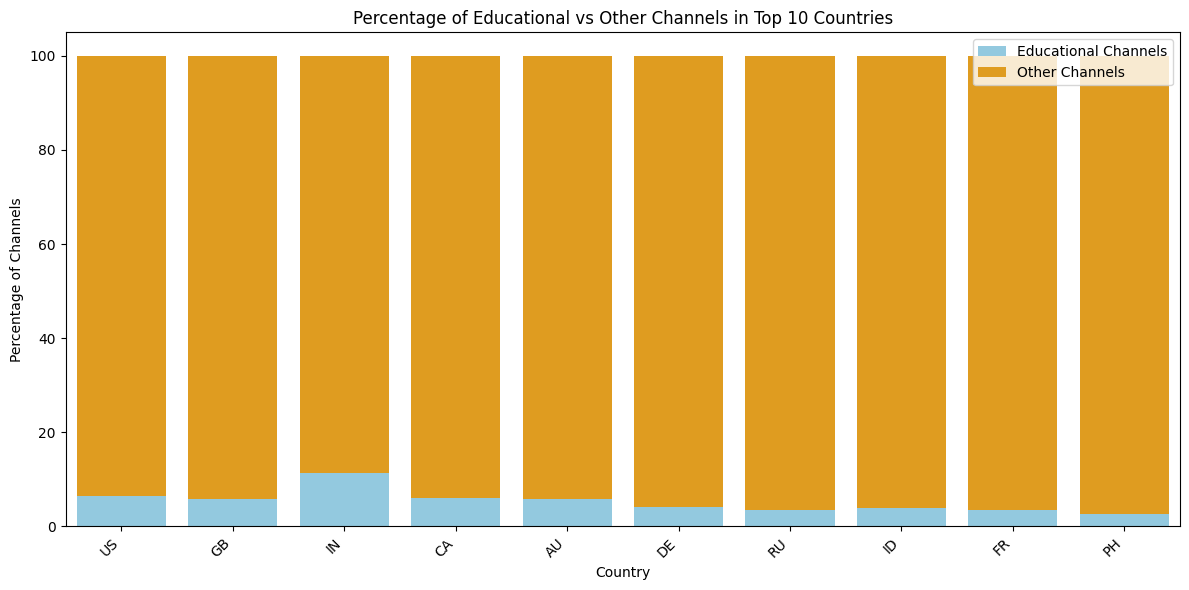

In [9]:
# Calculate the percentage of educational channels and other channels for each country
edu_country_counts = df_channel_edu['country'].value_counts()
other_country_counts = df_channel_other['country'].value_counts()

# Find the top 10 countries based on total channel counts
total_counts = edu_country_counts.add(other_country_counts, fill_value=0)
top_10_countries = total_counts.nlargest(10).index

# Create data for the plot
data = []
for country in top_10_countries:
    edu_count = edu_country_counts.get(country, 0)
    other_count = other_country_counts.get(country, 0)
    total_count = edu_count + other_count

    # Calculate percentages
    edu_percentage = (edu_count / total_count) * 100 if total_count > 0 else 0
    other_percentage = (other_count / total_count) * 100 if total_count > 0 else 0

    data.append({'country': country, 'edu_percentage': edu_percentage, 'other_percentage': other_percentage})

# Convert to DataFrame
df_plot = pd.DataFrame(data)

# Plot the stacked bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='country', y='edu_percentage', data=df_plot, color='skyblue', label='Educational Channels')
sns.barplot(x='country', y='other_percentage', data=df_plot, color='orange', label='Other Channels', bottom=df_plot['edu_percentage'])

# Customize the plot
plt.xlabel('Country')
plt.ylabel('Percentage of Channels')
plt.title('Percentage of Educational vs Other Channels in Top 10 Countries')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

The figure shows the top 10 countries based on percentage of all channel counts.
India (IN) has a higher percentage of educational content compared to other countries even though.

## Many people say... When studying STEM, no matter how hard or how strange a subject is, there's always an Indian Tutor on YouTube to help us pass our exams. Really?

# Now let's take a look at the trend for STEM content...

To identify STEM content, we filtered educational videos using a set of keywords deriving from STEM subjects crawled from MIT OCW. Further details can be found in our project's README, and the code for data preprocessing (STEM video filtering) can be found in src > data_processing

In [6]:
# Load total edu video and STEM video data
df_videos = pd.read_csv('videos/videos_edu_with_country_nonan.csv')
df_stem_videos = pd.read_csv('videos/videos_stem.csv')

<ipython-input-6-4b0a8e476d29>:2: DtypeWarning: Columns (3,5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_videos = pd.read_csv('videos/videos_edu_with_country_nonan.csv')


In [34]:
len(df_videos)

2075530

In [35]:
len(df_stem_videos)

74717

In [36]:
df_stem_videos.sample(10)

,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,name_cc,subscribers_cc,country,is_stem_title,title_matched_keywords,is_stem_tags,tag_matched_tags,tag_matched_keywords
5295,Education,UCsyZSg-iA7aN6C_jJ2hcLNw,2019-11-21 19:09:10.191864,0.0,6l_8-FEQfgc,859,5.0,"restriction fragment length polymorphism,RFLP,...",Forensic DNA typing procedure,2016-04-07 00:00:00,1442.0,Nikolay's Genetics L...,12149.0,US,True,dna,True,"DNA, Genetics, genome, molecular biology, pate...","dna, genetics, genome, molecular biology, testing"
40850,Education,UCUGsMIdvF7TOX_riaBFSvnw,2019-11-03 19:05:39.030922,37.0,tBPr1GX_8Fg,87,65.0,"Impedance relay,protective relay,What is imped...",Impedance or Distance Relay: Impedance relay i...,2017-04-22 00:00:00,15017.0,chrvoje engineering,32700.0,HR,True,distance,True,Impedance relay in distance protection of Powe...,"distance, ratio, torque"
23990,Education,UCcv7pspGHmM7AOywuLM1ufA,2019-11-14 09:01:07.564001,2.0,ZWGUe-OaYAo,3719,10.0,"coordinate geometry,jee mains,jee advanced,IIT...",CLASS 11 | COORDINATE GEOMETRY || LOCUS OF POI...,2018-08-06 00:00:00,412.0,Doubtnut,219000.0,IN,True,rotation,True,"rotation, rotation of axis",rotation
41172,Education,UCTcyOom6rr75j9ht0FVC_jg,2019-11-22 08:09:12.298543,8.0,CO2b6nJ3TbY,510,390.0,"funny,faces,everyday,objects,funny faces,every...",Funny Face in Everyday Objects!,2017-03-26 00:00:00,3045.0,Kelvin Ni,165000.0,US,True,objects,True,"Funny Faces in everyday objects, everyday funn...",objects
64057,Education,UCA7OQkX9AEIVQ6j9i0OSQhA,2019-11-23 11:16:41.343105,4.0,avRyR6BEi9I,3238,52.0,"Organization of HR Department and HR Policies,...",Lecture 2 : Organization of HR Department and ...,2016-05-03 00:00:00,5353.0,cec,281000.0,IN,True,organization,True,Organization of HR Department and HR Policies,organization
31762,Education,UCbQDhzxvT8kGpDdjZT19VQg,2019-11-18 17:42:32.097090,1.0,HhR8Tv_-_to,773,42.0,"Youth,Poetry,Spoken Word,Advocacy,Slam Poetry,...",2015 - 18th Annual Bringing the Noise for MLK ...,2015-03-02 00:00:00,2431.0,Youth Speaks,176000.0,US,True,noise,True,"Bringing the Noise, Bringing the Noise for Dr....",noise
10318,Education,UCpdkWp2zh5Qv1ZWlnqswdCw,2019-11-04 15:12:53.468606,1.0,NOSZdMz5d6Y,3406,7.0,"android php mysql user registration,register u...",Android PHP MySQL User Registration Ep.01 - R...,2016-06-09 00:00:00,1443.0,ProgrammingWizards T...,13200.0,KE,True,php,True,"android php mysql user registration, user regi...",php
45775,Education,UCPiuJvuyMVFSwcIdBCTpTyQ,2019-11-17 02:22:06.927872,6.0,eWbacvoqBPU,560,67.0,"energy,semiconductor,insulator,conductor,energ...",Energy Band Theory - Semiconductors (Chapter 1...,2018-12-18 00:00:00,2748.0,Dronstudy.com,914000.0,IN,True,"energy, physics, semiconductors",True,"band structure, band structure diagram, electr...","energy, physics, structure"
11470,Education,UCn2JOViAAWssWefchGpTNvw,2019-11-17 12:54:10.714930,0.0,niy93tCNoQI,188,2.0,"ADHD Stock Technical Analysis Stock Chart,ADHD...",Alcobra Ltd - ADHD Stock Chart Technical Analy...,2016-09-29 00:00:00,226.0,ClayTrader,187000.0,US,True,"adhd, analysis",True,"ADHD Stock Technical Analysis Chart Review, AD...","adhd, analysis"
58936,Education,UCEBb1b_L6zDS3xTUrIALZOw,2019-11-08 18:49:00.631919,8.0,rMsu4v-UlkA,3533,307.0,"payoff diagram,volatility,volatility implied i...",Ses 11: Options II,2013-05-10 00:00:00,53369.0,MIT OpenCourseWare,2084328.0,US,True,ses,True,"derivative security, volatility, volatility im...","derivative, volatility"


<ipython-input-37-211237944fe7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_countries["total_percentage"] = (top_10_countries["count"] / len(df_videos)) * 100


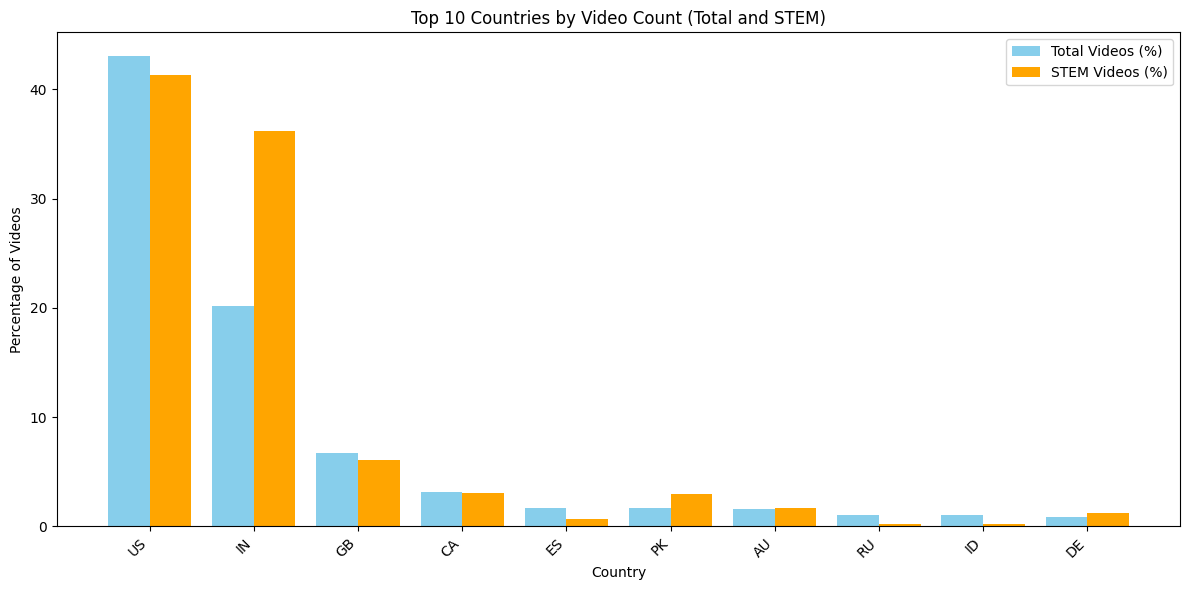

In [37]:
# Group by country and count videos
country_counts = df_videos.groupby("country").size().reset_index(name='count').sort_values('count', ascending=False)

# Get the top 10 countries
top_10_countries = country_counts.head(10)

# Calculate relative percentages
top_10_countries["total_percentage"] = (top_10_countries["count"] / len(df_videos)) * 100

# Similarly, use pandas methods for stem_country_counts
stem_country_counts = df_stem_videos.groupby("country").size().reset_index(name='count').sort_values('count', ascending=False)

# Merge dataframe
top_10_countries = pd.merge(top_10_countries, stem_country_counts, on="country", how="left", suffixes=("_total","_stem"))
top_10_countries["stem_percentage"] = (top_10_countries["count_stem"] / len(df_stem_videos)) * 100
top_10_countries.fillna(0, inplace=True)

# Plotting
plt.figure(figsize=(12, 6))

bar_width = 0.4

# Total Video Percentage
plt.bar(np.arange(len(top_10_countries)), top_10_countries["total_percentage"], width=bar_width, label="Total Videos (%)", color='skyblue')

# STEM Video Percentage
plt.bar(np.arange(len(top_10_countries)) + bar_width, top_10_countries["stem_percentage"], width=bar_width, label="STEM Videos (%)", color='orange')


plt.xlabel("Country")
plt.ylabel("Percentage of Videos")
plt.title("Top 10 Countries by Video Count (Total and STEM)")
plt.xticks(np.arange(len(top_10_countries)) + bar_width / 2, top_10_countries["country"], rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

From the above graph, it seems like the US and India has the significance of STEM Videos percentage compared to others. Let's take a deeper look into this:

In [38]:
# Convert the 'upload_date' column to datetime objects
df_stem_videos['upload_date'] = pd.to_datetime(df_stem_videos['upload_date'], format="%Y-%m-%d %H:%M:%S")

# Extract the year from the 'upload_date'
df_stem_videos['upload_year'] = df_stem_videos['upload_date'].dt.year

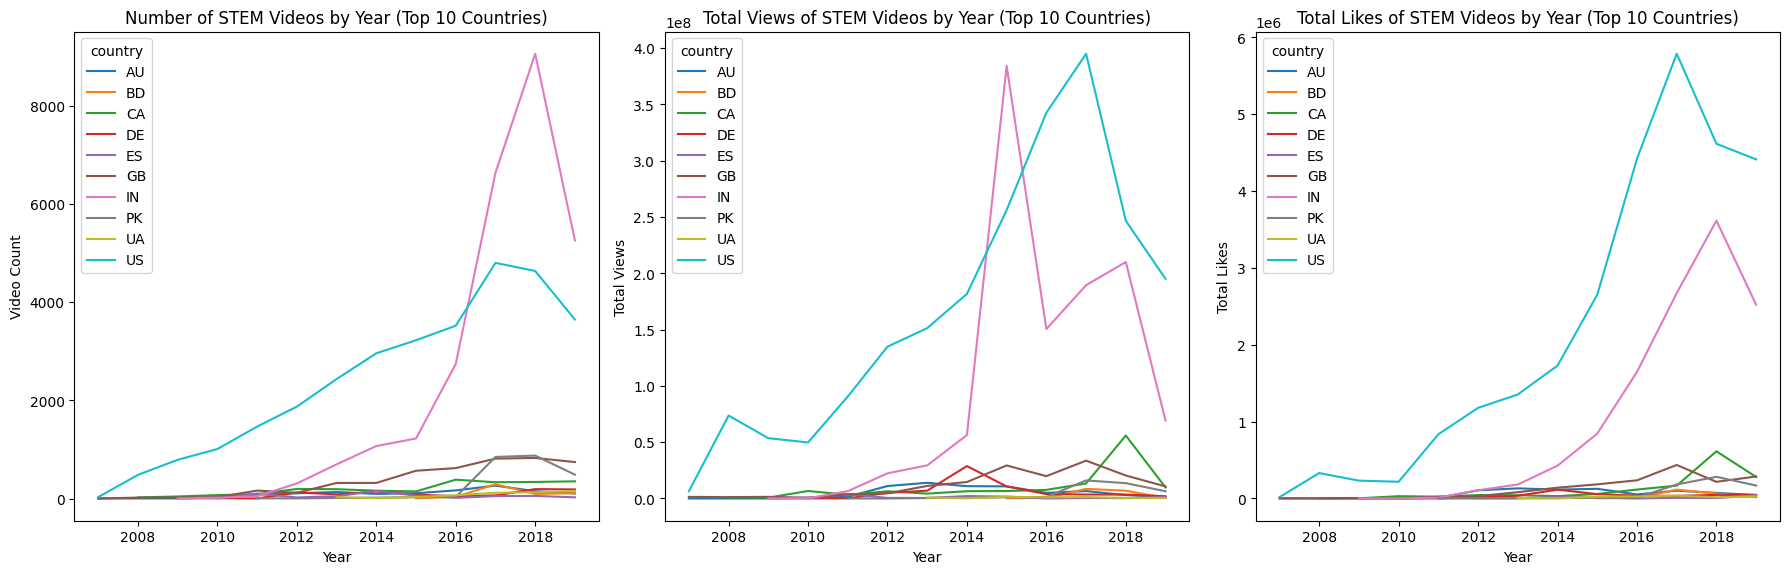

In [39]:
# Group data by country and year
grouped_data = df_stem_videos.groupby(["country", "upload_year"]).agg(
    video_count=("upload_year", "size"),
    total_views=("view_count", "sum"),
    total_likes=("like_count", "sum")
).reset_index()

# Get the top 10 countries with the most STEM videos
stem_country_counts = grouped_data.groupby("country")["video_count"].sum().reset_index()
stem_country_counts = stem_country_counts.rename(columns={"video_count": "count"})
top_10_countries = stem_country_counts.sort_values("count", ascending=False).head(10)
top_10_countries_list = top_10_countries["country"].tolist()

# Filter data for the top 10 countries
top_10_df = grouped_data[grouped_data["country"].isin(top_10_countries_list)]

# Plotting
plt.figure(figsize=(18, 6))

# Setting the hue order
sorted_countries = sorted(top_10_df['country'].unique())

# Video count
plt.subplot(1, 3, 1)
sns.lineplot(x="upload_year", y="video_count", hue="country", hue_order=sorted_countries, data=top_10_df)
plt.title("Number of STEM Videos by Year (Top 10 Countries)")
plt.xlabel("Year")
plt.ylabel("Video Count")

# View count
plt.subplot(1, 3, 2)
sns.lineplot(x="upload_year", y="total_views", hue="country", hue_order=sorted_countries, data=top_10_df)
plt.title("Total Views of STEM Videos by Year (Top 10 Countries)")
plt.xlabel("Year")
plt.ylabel("Total Views")

# Like count
plt.subplot(1, 3, 3)
sns.lineplot(x="upload_year", y="total_likes", hue="country", hue_order=sorted_countries, data=top_10_df)
plt.title("Total Likes of STEM Videos by Year (Top 10 Countries)")
plt.xlabel("Year")
plt.ylabel("Total Likes")

plt.tight_layout()
plt.show()

The United States and India are the leading contributors to STEM video production, views, and engagement. The US emerged early as the dominant player in STEM content, with steady growth in video production, views, and likes. In contrast, India experienced a rapid and aggressive rise starting around 2014, significantly increasing production, viewership, and engagement. Notably, Indian creators surpassed US viewership between 2014 and 2016 before experiencing a decline. Despite India’s surge, the US maintains higher overall engagement, consistently outperforming other countries in total likes and sustaining strong viewership trends.

This highlights the US’s long-standing dominance and India’s rapid growth in the STEM content landscape. Though is this growth stable?

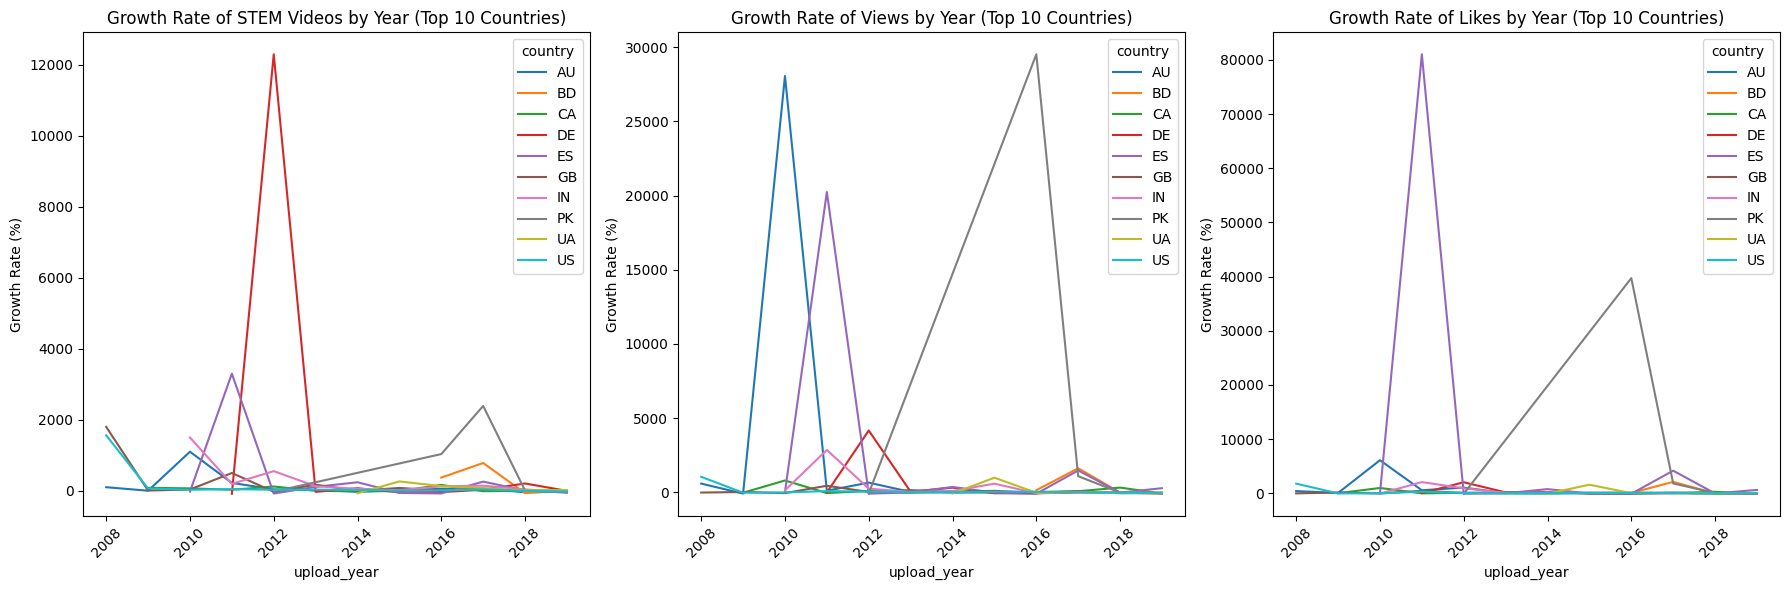

In [40]:
# Calculate year-over-year percentage change
def calculate_growth_rate(df, group_by, column, new_column_name):
    df_sorted = df.sort_values([group_by, 'upload_year'])
    df[new_column_name] = df.groupby(group_by)[column].pct_change() * 100
    return df

# Create a copy to avoid overwriting the original dataframe
top_10_growth_df = top_10_df.copy()

# Apply the function to calculate growth rates
top_10_growth_df = calculate_growth_rate(top_10_growth_df, 'country', 'video_count', 'video_growth_rate')
top_10_growth_df = calculate_growth_rate(top_10_growth_df, 'country', 'total_views', 'views_growth_rate')
top_10_growth_df = calculate_growth_rate(top_10_growth_df, 'country', 'total_likes', 'likes_growth_rate')

# Plotting
plt.figure(figsize=(18, 6))

# Number of videos growth rate
plt.subplot(1, 3, 1)
sns.lineplot(x="upload_year", y="video_growth_rate", hue="country", hue_order=sorted_countries, data=top_10_growth_df)
plt.title("Growth Rate of STEM Videos by Year (Top 10 Countries)")
plt.xticks(rotation=45)
plt.ylabel("Growth Rate (%)")

# Total views growth rate
plt.subplot(1, 3, 2)
sns.lineplot(x="upload_year", y="views_growth_rate", hue="country", hue_order=sorted_countries, data=top_10_growth_df)
plt.title("Growth Rate of Views by Year (Top 10 Countries)")
plt.xticks(rotation=45)
plt.ylabel("Growth Rate (%)")

# Total likes growth rate
plt.subplot(1, 3, 3)
sns.lineplot(x="upload_year", y="likes_growth_rate", hue="country", hue_order=sorted_countries, data=top_10_growth_df)
plt.title("Growth Rate of Likes by Year (Top 10 Countries)")
plt.xticks(rotation=45)
plt.ylabel("Growth Rate (%)")

plt.tight_layout()
plt.show()


While other countries also had certain surges of STEM videos content creation at some point in time, they seem to eventually die down. India, on the other hand, while only witnessed a small peak around 2012, and but then keep growing at a stable rate.

In [7]:
df_stem_india = df_stem_videos[df_stem_videos['country'] == 'IN']
print(f"Total number of STEM videos from India: {len(df_stem_india)}")
df_stem_india_counts = df_stem_india['name_cc'].value_counts()
print(f"Number of unique STEM videos from India: {len(df_stem_india_counts)}")
df_stem_india_counts

Total number of STEM videos from India: 27049
Number of unique STEM videos from India: 472


,count
name_cc,
Doubtnut,3058
Ekeeda,2822
Durga Software Solut...,2420
Pradeep Kshetrapal,1149
Geeky Shows,1119
...,...
Tech Garden,1
Skill Bill : Tally G...,1
BV Pattabhiram,1


The data reveals a notable concentration of Indian content creators producing educational or STEM-related content, with 27049 videos of 74717 STEM-classified videos. Specifically:

Channels like DoubtNut (3058 videos), Ekeeda (2822 videos), and Durga Software Solutions (2420 videos) are among the most prolific.
472 unique content creators, indicating a wide range of contributors in the field. There are many smaller channels with just one video each, highlighting a long tail of niche creators.

# Idk yet - Channel and video characteristics?
## Topic breakdown - What are they teaching on Yt?

Let's get our keyword list back to match our STEM content to the subject that it's associated with:

In [4]:
def load_keywords(filepath):
    keywords_dict = {}
    with open(filepath, 'r') as file:
        for line in file:
            match = re.match(r"(\w+_keywords)\s*=\s*\[(.*?)\]", line)
            if match:
                category_name = match.group(1)
                keywords_str = match.group(2)
                keywords_list = [keyword.strip("'\" ") for keyword in keywords_str.lower().split(',')]

                # Extract category (e.g., "science" from "science_keywords")
                category = " ".join(category_name.split("_")[:-1])

                keywords_dict[category] = set(keywords_list)
    return keywords_dict

# Example usage (assuming final_keywords.txt is in your current directory):
keywords_data = load_keywords('final_keywords.txt')

In [5]:
keywords_data.keys()

dict_keys(['science', 'physics', 'atomic molecular optical physics', 'theoretical physics', 'condensed matter physics', 'nuclear physics', 'particle physics', 'astrophysics', 'quantum mechanics', 'electromagnetism', 'chemistry', 'physical chemistry', 'analytical chemistry', 'organic chemistry', 'inorganic chemistry', 'biology', 'biochemistry', 'molecular biology', 'genetics', 'neurobiology', 'structural biology', 'synthetic biology', 'microbiology', 'virology', 'anatomy and physiology', 'earth science', 'engineering', 'electrical engineering', 'digital systems', 'signal processing', 'electronics', 'telecommunications', 'electric power', 'mechanical engineering', 'solid mechanics', 'thermodynamics', 'transport processes', 'robotics and control systems', 'systems engineering', 'systems optimization', 'systems design', 'materials science and engineering', 'chemical engineering', 'environmental engineering', 'energy', 'biological engineering', 'cell and tissue engineering', 'biomedical sig

We now match the subject category back to each video by their matched title and tag keywords.

In [49]:
# Prepare keywords_count dictionary
keywords_count = defaultdict(int)

# Helper function to generate n-grams
def generate_ngrams(text, n):
    words = text.split()
    return [" ".join(words[i:i+n]) for i in range(len(words)-n+1)]

# Function to process a single row
def process_row(idx, row):
    matched_keywords = set(row["title_matched_keywords"].split(", ") + row["tag_matched_keywords"].split(", "))
    matched_categories = set()

    for category, keywords in keywords_data.items():
        for keyword in keywords:
            n = len(keyword.split())  # Determine n for n-grams
            for matched_keyword in matched_keywords:
                ngrams = generate_ngrams(matched_keyword, n)
                if keyword in ngrams:
                    keywords_count[category] += 1
                    matched_categories.add(category)

    return idx, ", ".join(matched_categories)

# Add new column for matched_category
df_stem_india["matched_category"] = ""

# Process rows with ThreadPoolExecutor
with ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(lambda x: process_row(x[0], x[1]), df_stem_india.iterrows()), total=len(df_stem_india)))

# Update DataFrame with results
for idx, matched_category in results:
    df_stem_india.at[idx, "matched_category"] = matched_category


100%|██████████| 27049/27049 [03:54<00:00, 115.58it/s]


In [68]:
df_stem_india[['title','title_matched_keywords','tag_matched_keywords','matched_category']].sample(10)

,title,title_matched_keywords,tag_matched_keywords,matched_category
66665,Phy-X-12-04 Electric Current Pradeep Kshetrapa...,physics,physics,physics
22966,If X and Y are two sets such that has 18 eleme...,sets,sets,mathematical analysis
20550,स्वतंत्रता दिवस | Independence Day Story | 15 ...,independence,independence,probability and statistics
2676,NEET / AIIMS 2018 - Human health & disease Lec...,aids,aids,"biology, science"
30398,Learn JAVASCRIPT Online Training || Class - 5 ...,javascript,"java, javascript",programming languages
61281,Modern Theory Of Catalysis(Explanation),catalysis,catalysis,"chemistry, thermodynamics"
67590,"XII 49 Electro Magnetic Induction, Faraday's Laws",induction,"induction, physics","applied mathematics, discrete mathematics, mat..."
22401,JEE MAINS 2018 The length of the shortest dist...,distance,physics,"physics, graphics and visualization"
4796,Adjoint & Inverse of Matrix in Hindi,matrix,"determinants, matrix",linear algebra
71301,PHP video tutorial 40 - PHP if else Statement ...,php,"control, development, php","biology, electrical engineering, programming l..."


Now let's see what STEM subjects that Indians teach the most!

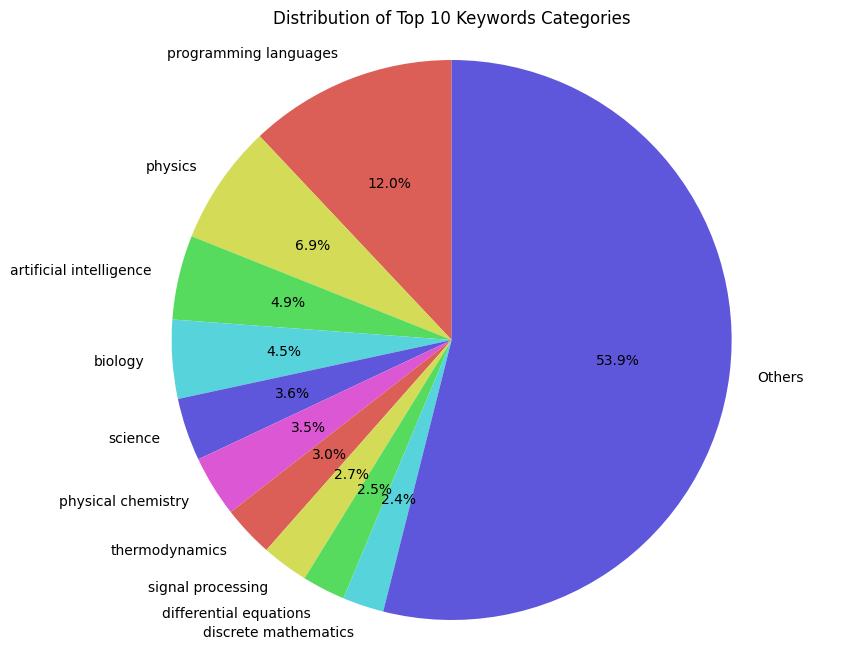

In [60]:
# Sort keywords by count in descending order
sorted_keywords = dict(sorted(keywords_count.items(), key=lambda item: item[1], reverse=True))

# Take the top 10 categories
top_10_keywords = dict(list(sorted_keywords.items())[:10])

# Calculate the sum of counts for the remaining categories
other_count = sum(sorted_keywords.values()) - sum(top_10_keywords.values())

# Add "Others" to the top 10 keywords
top_10_keywords["Others"] = other_count

colors = sns.color_palette('hls')[0:12]

# Create the pie chart
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
plt.pie(top_10_keywords.values(), labels=top_10_keywords.keys(), autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribution of Top 10 Keywords Categories')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Top subjects are programming languages, followed by physics, AI and biology. Let's also look at how these subjects have emerged overtime.

In [54]:
# Convert the 'upload_date' column to datetime objects
df_stem_india['upload_date'] = pd.to_datetime(df_stem_india['upload_date'], format="%Y-%m-%d %H:%M:%S")

# Extract the year from the 'upload_date'
df_stem_india['upload_year'] = df_stem_india['upload_date'].dt.year

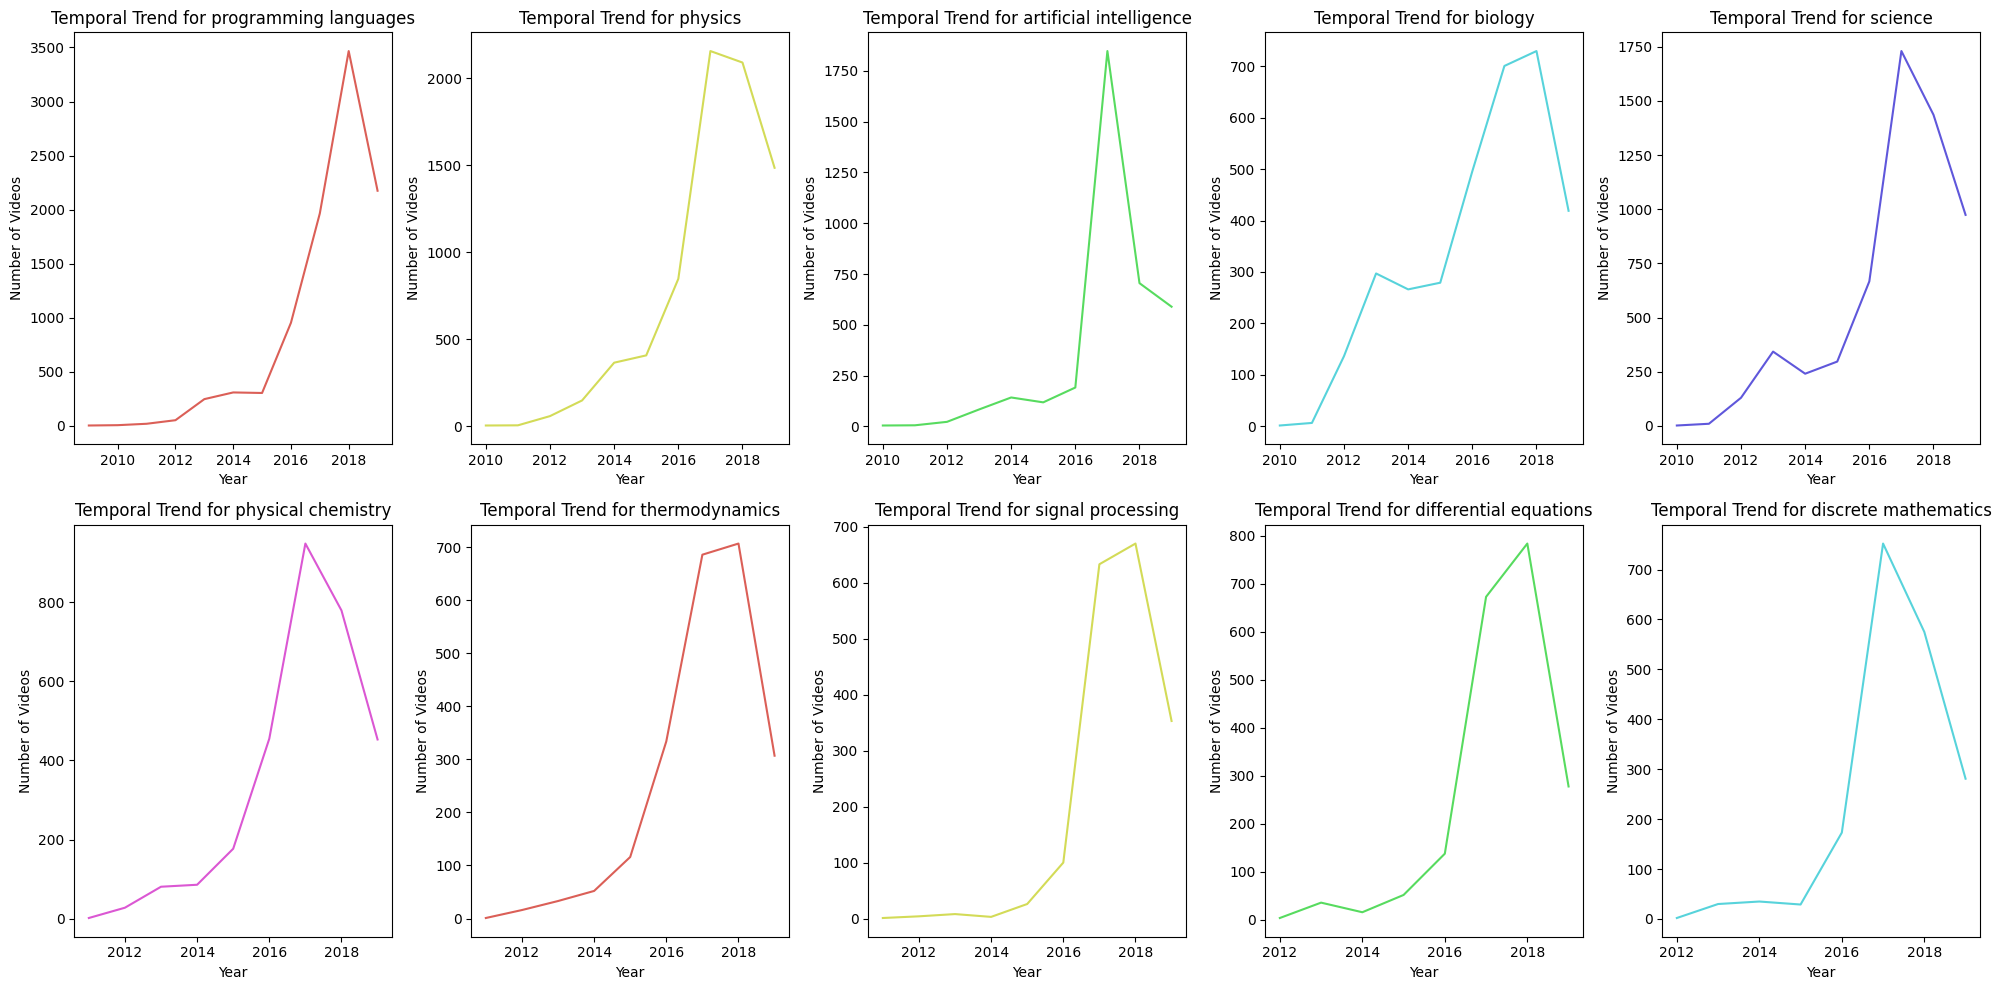

In [66]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.ravel()

for i, category in enumerate(list(top_10_keywords.keys())[:10]):
    # Filter data for the current category
    category_data = df_stem_india[df_stem_india['matched_category'].str.contains(category, na=False)]

    # Group by year and count videos
    yearly_counts = category_data.groupby('upload_year').size().reset_index(name='counts')

    # Plot the trend with a specific color
    sns.lineplot(x='upload_year', y='counts', data=yearly_counts, ax=axes[i], color=colors[i%6])
    axes[i].set_title(f'Temporal Trend for {category}')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Number of Videos')

plt.tight_layout()
plt.show()


TODO (/potential ideas):
* Use the same code to get content breakdown of other countries, and also temporal trend -> to see if they are teaching the same subject, or whether there's any "globalization" effect
* Analyze the characteristics of ("successful") channels: monetization strategy (maybe even just binary), "activity" (how often do they produce vids? - might need to use the other time serires data)
  * --> **Make a correlation matrix of these characteristics** (e.g video duration, monetization, channel activity, etc) **vs "success" metrics** (e.g like, view, subscribers, etc) - *Are there certain factors that make them successful?*
* Use timeseries data? For tracking the activity of channels? But in the occasion of what?
  e.g Looking into some specific subject or phenomenon e.g Are there surging activities during exam season (May/December?)
* ... Anything interesting idk

### Testing preliminary code on correlation analysis



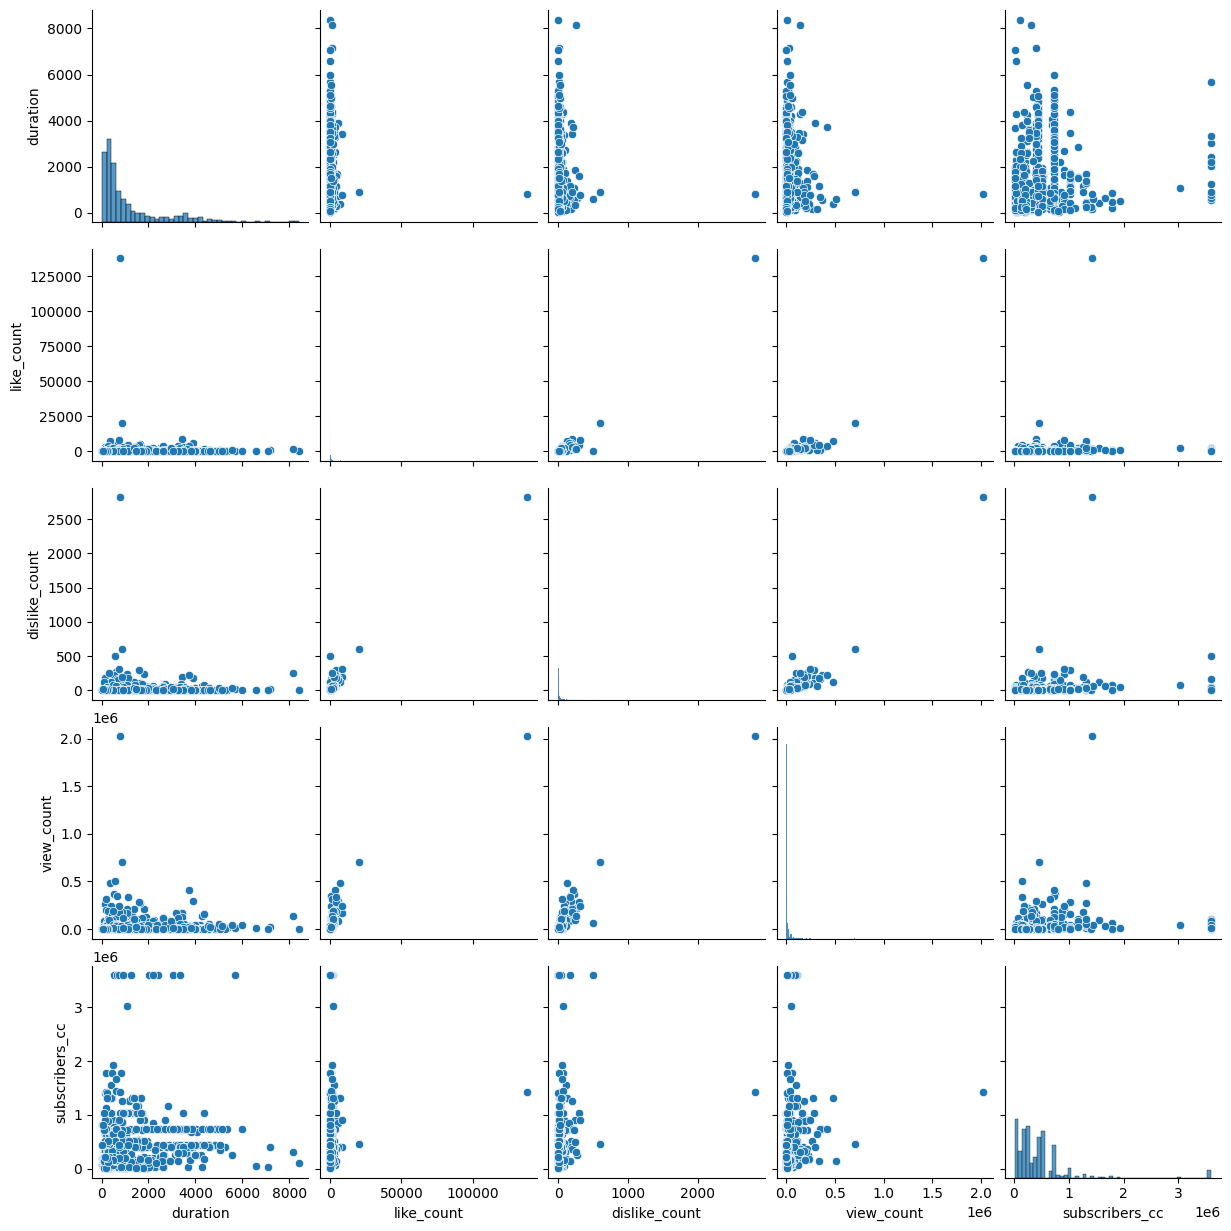

In [76]:
# Running the whole thing took soooooooo long so just testing a subsample first
sns.pairplot(df_stem_india.sample(1000)[['duration', 'like_count', 'dislike_count', 'view_count', 'subscribers_cc']])

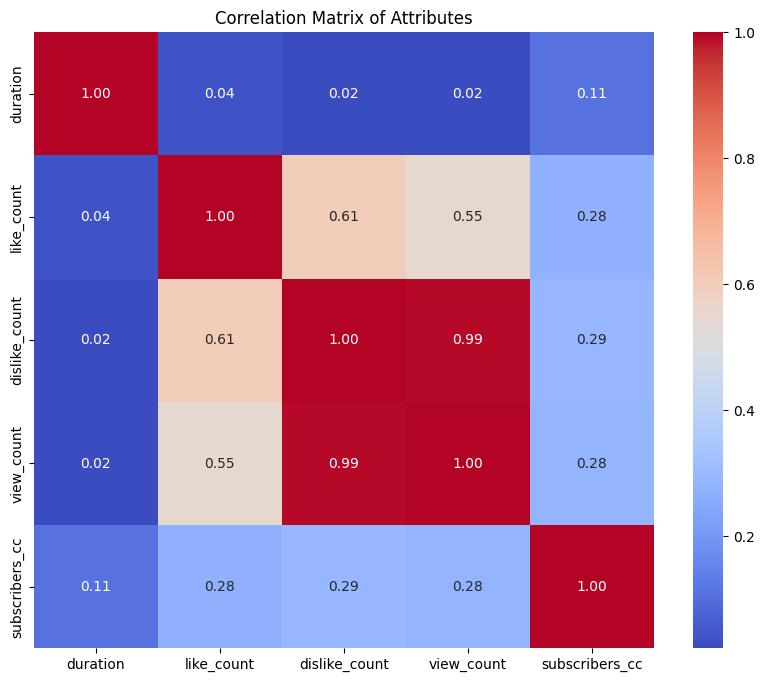

In [78]:
correlation_columns = ['duration', 'like_count', 'dislike_count', 'view_count', 'subscribers_cc']
df_correlation = df_stem_india[correlation_columns]

# Calculate the correlation matrix
correlation_matrix = df_correlation.corr()

# Create a heatmap to visualize the correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Attributes')
plt.show()

^ Just testing and from this graph there's nothing much (only view and dislike correlate with each other!??! Indian creators have a lot of haters or what!?)... But in later analysis, we can try investigating more channel characteristics (e.g monetization, channel activity etc) - just for exploring but also to have more factors to draw the correlation matrix